In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', start='2014-12-31', end='2022-12-31', interval='1d')
#data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
...,...,...,...,...,...,...
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920


In [3]:
data= data.to_csv('btc-2015-2022_case2.csv')

In [5]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [4]:
data_csv = pd.read_csv('btc-2015-2022_case2.csv')
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 2922 entries, 2014-12-31 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2922 non-null   float64
 1   High       2922 non-null   float64
 2   Low        2922 non-null   float64
 3   Close      2922 non-null   float64
 4   Adj Close  2922 non-null   float64
 5   Volume     2922 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 159.8+ KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-21,16904.527344,16916.800781,16755.912109,16817.535156,16817.535156,14882945045
2022-12-22,16818.380859,16866.673828,16592.408203,16830.341797,16830.341797,16441573050
2022-12-23,16829.644531,16905.218750,16794.458984,16796.953125,16796.953125,15329265213
2022-12-24,16796.976562,16864.703125,16793.527344,16847.755859,16847.755859,9744636213
2022-12-25,16847.505859,16860.554688,16755.253906,16841.986328,16841.986328,11656379938
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479


In [5]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(2922, 6)

In [6]:
test_data =test_df.copy()

In [7]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [8]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 2337 entries, 2014-12-31 to 2021-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2337 non-null   float64
 1   High       2337 non-null   float64
 2   Low        2337 non-null   float64
 3   Close      2337 non-null   float64
 4   Adj Close  2337 non-null   float64
 5   Volume     2337 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 127.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 585 entries, 2021-05-25 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       585 non-null    float64
 1   High       585 non-null    float64
 2   Low        585 non-null    float64
 3   Close      585 non-null    float64
 4   Adj Close  585 non-null    float64
 5   Volume     585 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 32.0+ KB
None
test_data (585

In [9]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (2337, 5)
y_train (2337,)
X_test (585, 5)
y_test (585,)


In [10]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1)
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (2337, 5)
y_train (2337, 1)
X_test (585, 5)
y_test (585, 1)


In [11]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (2337, 1, 5)
y_train (2337, 1)
X_test (585, 1, 5)
Y_test (585, 1)
X_train.shape[1] 1
X_train.shape[2] 5


In [12]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
momodel = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=( X_train.shape[1], X_train.shape[2]),
                             return_sequences=True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(75, return_sequences=True, activation='tanh')))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(50, activation='tanh')))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy', 'mean_absolute_error'])


In [13]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
74/74 [==============================] - 63s 31ms/step - loss: 0.0138 - accuracy: 4.2790e-04 - mean_absolute_error: 0.0625
Epoch 2/1000
74/74 [==============================] - 2s 30ms/step - loss: 7.4635e-04 - accuracy: 8.5580e-04 - mean_absolute_error: 0.0138
Epoch 3/1000
74/74 [==============================] - 2s 32ms/step - loss: 6.3931e-04 - accuracy: 8.5580e-04 - mean_absolute_error: 0.0116
Epoch 4/1000
74/74 [==============================] - 2s 29ms/step - loss: 7.5631e-04 - accuracy: 8.5580e-04 - mean_absolute_error: 0.0136
Epoch 5/1000
74/74 [==============================] - 2s 29ms/step - loss: 4.9268e-04 - accuracy: 8.5580e-04 - mean_absolute_error: 0.0111
Epoch 6/1000
74/74 [==============================] - 2s 31ms/step - loss: 6.9917e-04 - accuracy: 8.5580e-04 - mean_absolute_error: 0.0126
Epoch 7/1000
74/74 [==============================] - 2s 32ms/step - loss: 7.9214e-04 - accuracy: 8.5580e-04 - mean_absolute_error: 0.0159
Epoch 8/1000
74/74 [==========

In [14]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


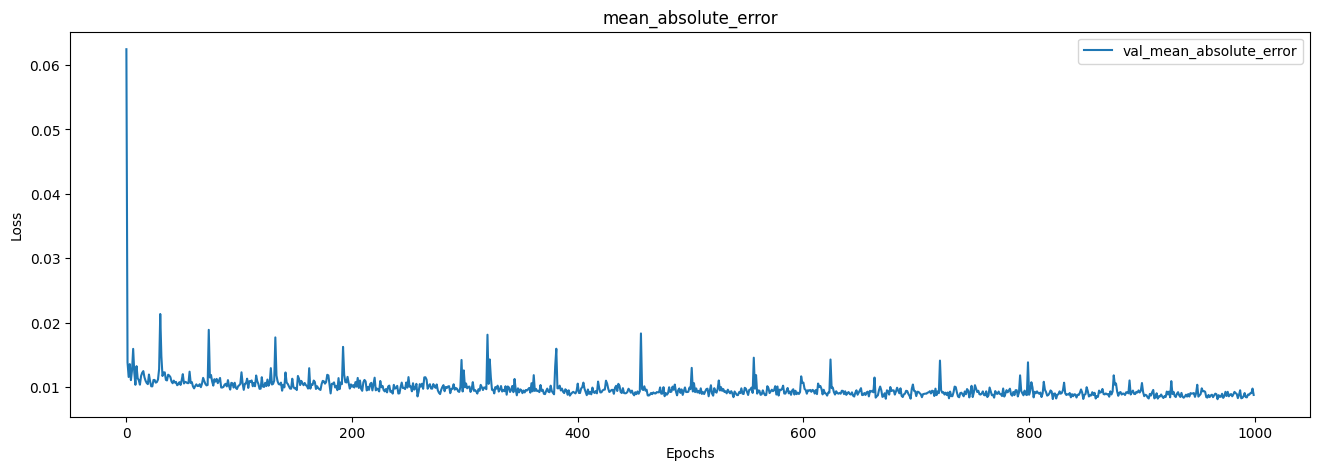

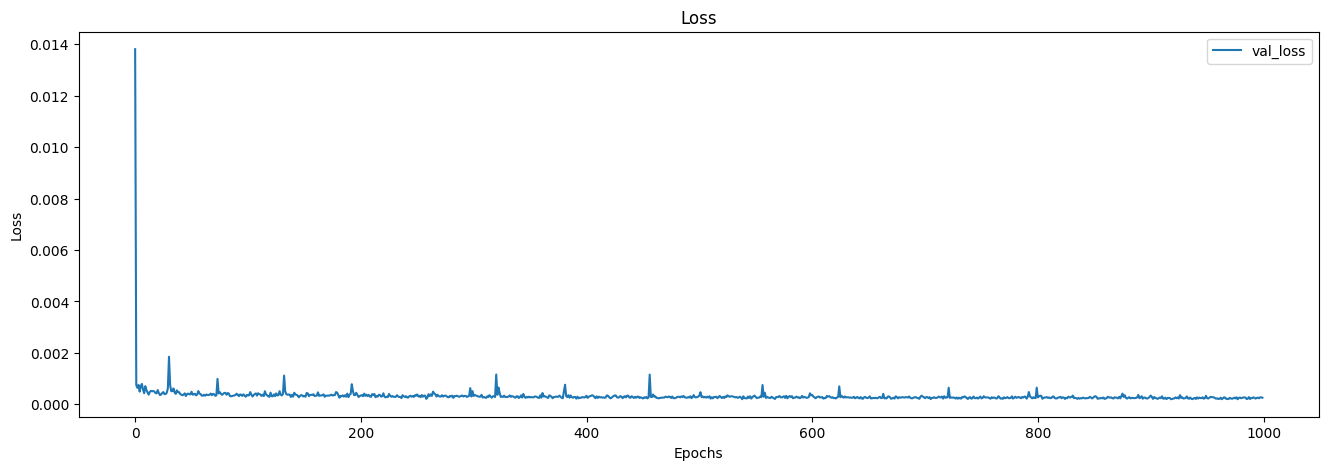

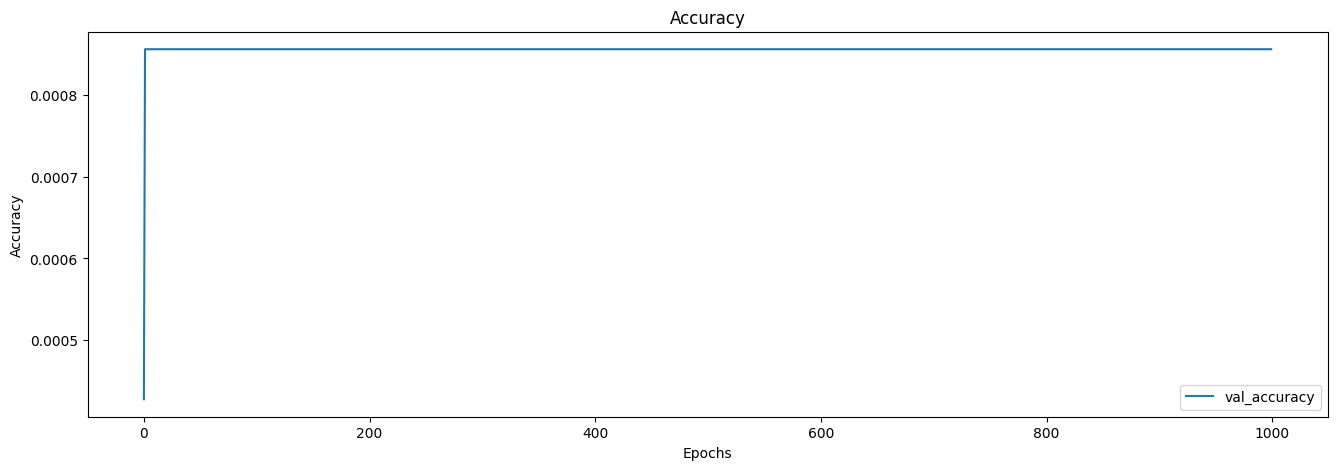

In [15]:
visualize_training_results(history)


In [16]:
# Evaluate the model on the test set
mse, accuracy, mae = model.evaluate(X_test, y_test)


19/19 [==============================] - 6s 8ms/step - loss: 6.2852e-05 - accuracy: 0.0034 - mean_absolute_error: 0.0047


In [17]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)




# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


19/19 [==============================] - 7s 10ms/step
y_pred (585, 1)
y_test (585, 1)
RMSE: 410.5037
MSE: 168513.3157
MAE:244.3170


In [ ]:
# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)


# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


In [18]:
y_pred

array([[38585.93 ],
       [39607.39 ],
       [38627.355],
       [36064.797],
       [34974.42 ],
       [35672.9  ],
       [37207.01 ],
       [36784.5  ],
       [37622.1  ],
       [39206.69 ],
       [37002.312],
       [35798.113],
       [35970.74 ],
       [33887.45 ],
       [33477.863],
       [37351.258],
       [36934.707],
       [37383.98 ],
       [35661.44 ],
       [38973.5  ],
       [40347.03 ],
       [40555.44 ],
       [38602.113],
       [38275.617],
       [35954.71 ],
       [35702.02 ],
       [35562.08 ],
       [32102.021],
       [32636.158],
       [33953.984],
       [34616.746],
       [31994.662],
       [32169.281],
       [34638.816],
       [34544.75 ],
       [36012.336],
       [35068.527],
       [33663.867],
       [33912.906],
       [34641.355],
       [35366.203],
       [33779.477],
       [34361.867],
       [34015.72 ],
       [32871.43 ],
       [33765.453],
       [33549.63 ],
       [34249.945],
       [33210.375],
       [32673.379],


In [20]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days يجب تعديل التاريخ اعتماداً على فترة الاختبار يجب ملاحظة ذلك 
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


# Assuming y_pred is a numpy array




In [21]:

#y_test_df.to_csv("y_test_2021_2022.csv")
y_test_df

,Adj Close
Date,
2021-05-25,38402.222656
2021-05-26,39294.199219
2021-05-27,38436.968750
2021-05-28,35697.605469
2021-05-29,34616.066406
...,...
2022-12-26,16919.804688
2022-12-27,16717.173828
2022-12-28,16552.572266


In [22]:
#y_pred_df.to_csv("y_pred_2021_2022.csv")  # index=False to exclude index column in CSV
y_pred_df


,Adj Close
Date,
2021-05-25,38585.929688
2021-05-26,39607.390625
2021-05-27,38627.355469
2021-05-28,36064.796875
2021-05-29,34974.421875
...,...
2022-12-26,16979.033203
2022-12-27,16809.681641
2022-12-28,16648.388672


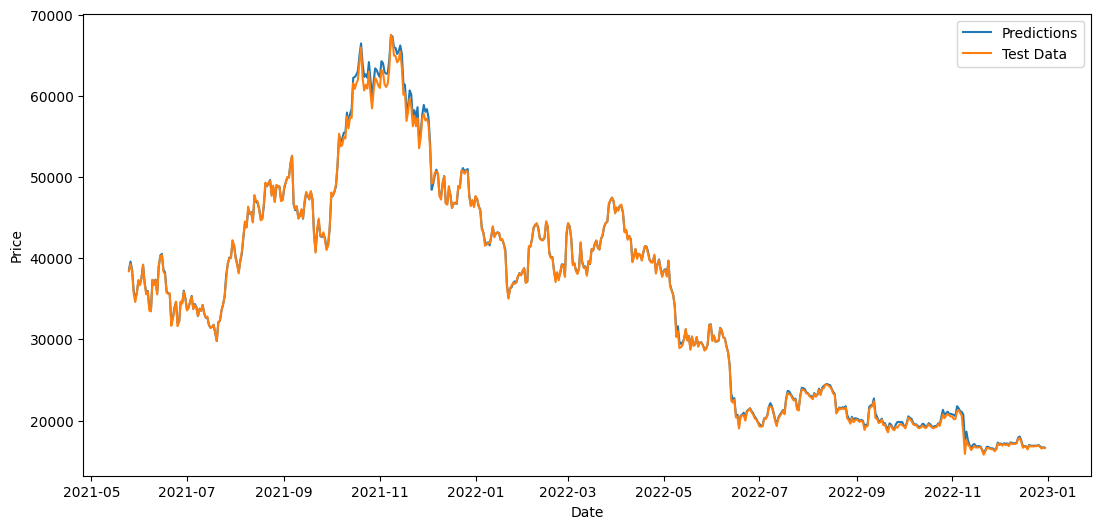

In [23]:
plt.figure(figsize=(13, 6))
plt.plot(y_pred_df, label='Predictions')
plt.plot(y_test_df, label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [24]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [25]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 0.7101%


In [26]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))


smape: 0.7038%


In [27]:
# Step 1: Data cleaning
#data = yf.download(tickers='BTC-usd', start='2014-12-31', end='2022-12-31', interval='1d')
data_new = yf.download(tickers='BTC-USD', period='max', interval='1d')
data_new.dropna(inplace=True)
data_new


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-03-03,23476.632812,23479.347656,22213.238281,22362.679688,22362.679688,26062404610
2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913
2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,22435.513672,13317001733


In [29]:
future_data = data_new.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Close","Adj Close", "Volume"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today, periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 5)
y_future_data: (30, 1)
x_future_data: (30, 5)
future_data_temp (30, 5)
future_data_temp (29, 5)
future_data_temp (28, 5)
future_data_temp (27, 5)
future_data_temp (26, 5)
future_data_temp (25, 5)
future_data_temp (24, 5)
future_data_temp (23, 5)
future_data_temp (22, 5)
future_data_temp (21, 5)


In [30]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 5)
1/1 [==============================] - 0s 101ms/step
future_data_temp2 (30, 1, 5)
---------------------------------------------------
future_data_temp1 (29, 5)
1/1 [==============================] - 0s 134ms/step
future_data_temp2 (29, 1, 5)
---------------------------------------------------
future_data_temp1 (28, 5)
1/1 [==============================] - 0s 163ms/step
future_data_temp2 (28, 1, 5)
---------------------------------------------------
future_data_temp1 (27, 5)
1/1 [==============================] - 0s 146ms/step
future_data_temp2 (27, 1, 5)
---------------------------------------------------
future_data_temp1 (26, 5)
1/1 [==============================] - 0s 107ms/step
future_data_temp2 (26, 1, 5)
---------------------------------------------------
future_data_temp1 (25, 5)
1/1 [==============================] - 0s 152ms/step
future_data_temp2 (25, 1, 5)
---------------------------------------------------
future_data_temp1 (24, 5)
1/1 [=========

In [31]:
prediction_df


,Adj Close
2023-03-09,22802.709074
2023-03-10,23257.420796
2023-03-11,22962.615929
2023-03-12,21929.724071
2023-03-13,21699.871824
2023-03-14,21859.650914
2023-03-15,21814.600760
2023-03-16,21798.778669
2023-03-17,22230.867453
2023-03-18,24018.665698


In [32]:
y_future_data


,Adj Close
Date,
2023-02-08,22760.109375
2023-02-09,23264.291016
2023-02-10,22939.398438
2023-02-11,21819.039062
2023-02-12,21651.183594
2023-02-13,21870.875000
2023-02-14,21788.203125
2023-02-15,21808.101562
2023-02-16,22220.804688


In [36]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_future_data.index[-1], y1=y_future_data['Adj Close'][-1],
              line=dict(color='grey', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [38]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


## التحديث لتنبوء باستخدام كامل الفترة واضافة ال10 اي المستقبلية 

In [41]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))
fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_pred_df.index[-1], y1=y_pred_df['Adj Close'][-1],
              line=dict(color='grey', width=2))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()
